# **Importing the required libraries**

In [5]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# **Visualize the Data**

In [6]:
from IPython.display import HTML
from base64 import b64encode


def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [7]:

NonViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"


NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)


Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

**Play Random Non Violence Video**

In [8]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

**Play Random Violence Video**

In [9]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

# **Extracting Frames**

In [10]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"
 
CLASSES_LIST = ["NonViolence","Violence"]

In [11]:
def frames_extraction(video_path):
 
    frames_list = []
    
    
    video_reader = cv2.VideoCapture(video_path)
 
   
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
         
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        
        normalized_frame = resized_frame / 255
        
        
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

# **Creating the Data**

In [12]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            frames = frames_extraction(video_file_path)
 
            if len(frames) == SEQUENCE_LENGTH:
 
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [13]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence


[h264 @ 0x5978bb9609c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5978bb9609c0] error while decoding MB 98 31
[h264 @ 0x5978bb9609c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5978bb9609c0] error while decoding MB 98 31
[h264 @ 0x5978bb9609c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5978bb9609c0] error while decoding MB 98 31
[h264 @ 0x5978bb9609c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5978bb9609c0] error while decoding MB 98 31


Extracting Data of Class: Violence


In [14]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [15]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [16]:

one_hot_encoded_labels = to_categorical(labels)

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [18]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


# **Importing MobileNet and Fine-Tuning it.**

In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False



9420800/9406464 [==============================] - 0s 0us/step


# **Building The Model**

In [20]:
def create_model():
 
    model = Sequential()

    ########################################################################################################################
    
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    
 
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 2, 2, 1280)    2257984   
_________________________________________________________________
dropout (Dropout)            (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 5120)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                1319168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

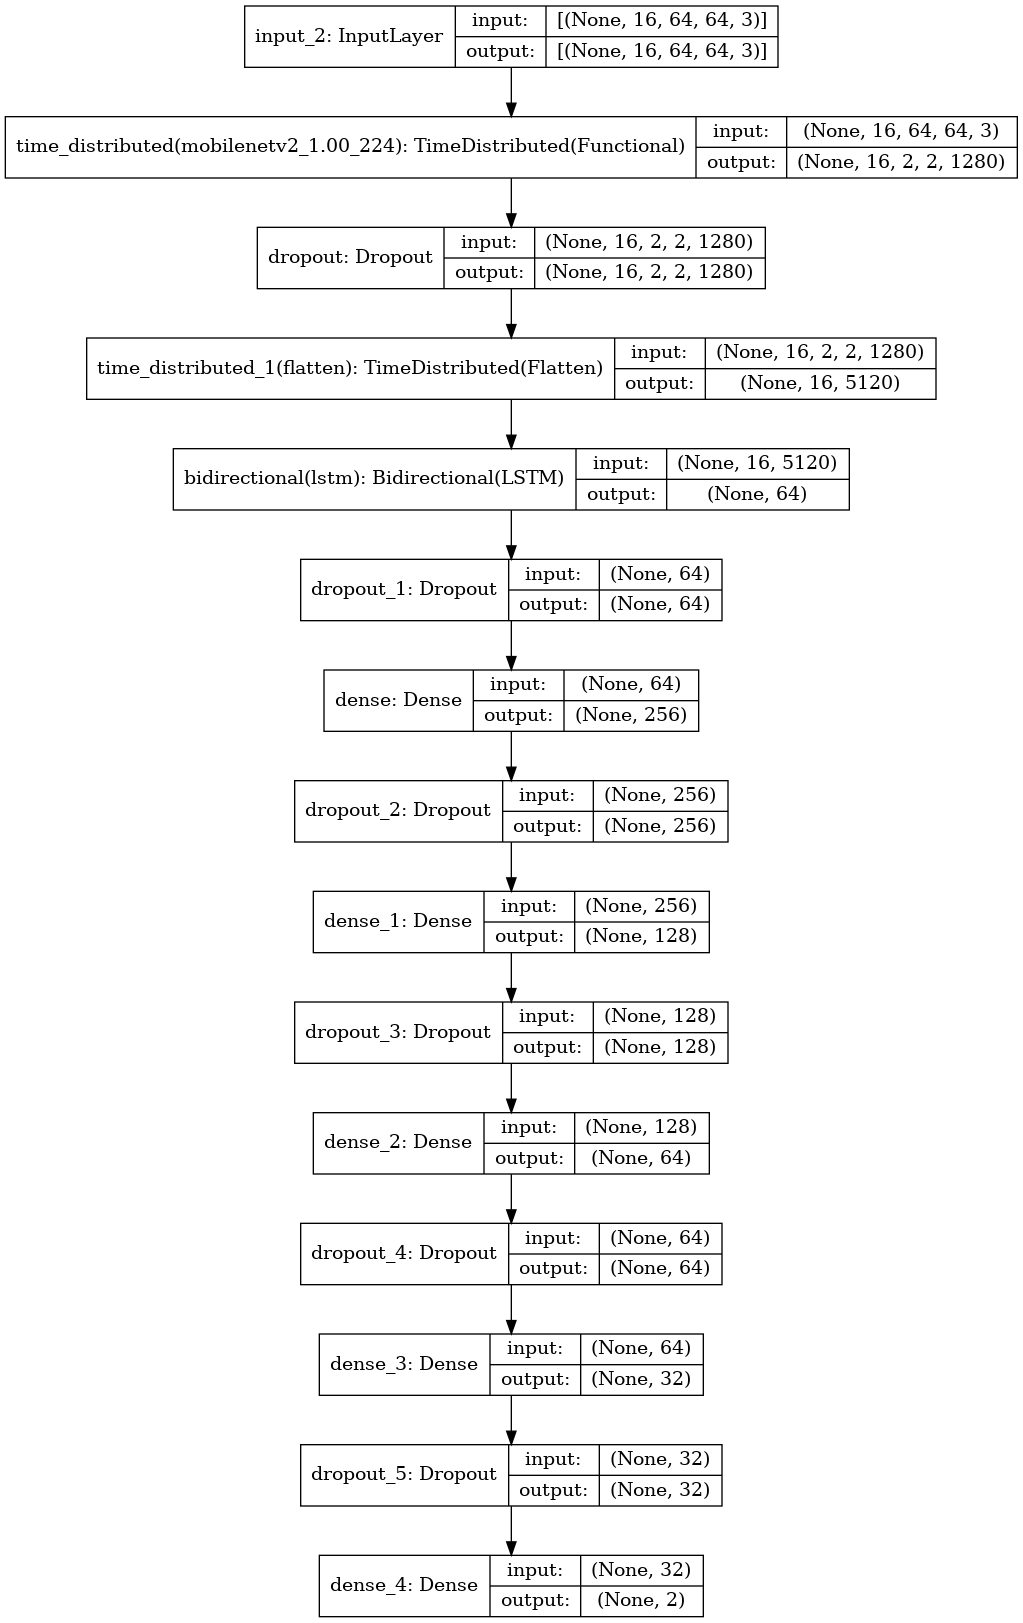

In [21]:
MoBiLSTM_model = create_model()

plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Specifying Callbacks and Fitting**

In [22]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
180/180 [==============================] - 21s 49ms/step - loss: 0.6926 - accuracy: 0.5167 - val_loss: 0.6786 - val_accuracy: 0.6028
Epoch 2/50
180/180 [==============================] - 7s 37ms/step - loss: 0.6647 - accuracy: 0.5861 - val_loss: 0.6513 - val_accuracy: 0.6111
Epoch 3/50
180/180 [==============================] - 7s 37ms/step - loss: 0.5725 - accuracy: 0.7264 - val_loss: 0.5489 - val_accuracy: 0.6889
Epoch 4/50
180/180 [==============================] - 7s 37ms/step - loss: 0.4661 - accuracy: 0.8049 - val_loss: 0.5591 - val_accuracy: 0.7389
Epoch 5/50
180/180 [==============================] - 7s 37ms/step - loss: 0.3914 - accuracy: 0.8576 - val_loss: 0.2730 - val_accuracy: 0.9000
Epoch 6/50
180/180 [==============================] - 7s 37ms/step - loss: 0.3272 - accuracy: 0.8882 - val_loss: 0.3859 - val_accuracy: 0.8667
Epoch 7/50
180/180 [==============================] - 7s 37ms/step - loss: 0.3032 - accuracy: 0.8903 - val_loss: 1.0024 - val_accuracy: 0.680

In [44]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 0s 49ms/step - loss: 0.2244 - accuracy: 0.9350


In [24]:
MoBiLSTM_model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# **Model Evaluation**

In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

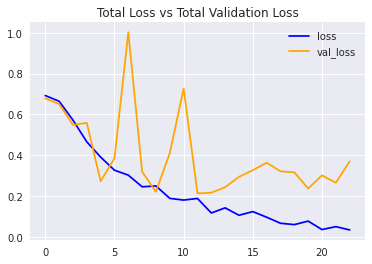

In [26]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

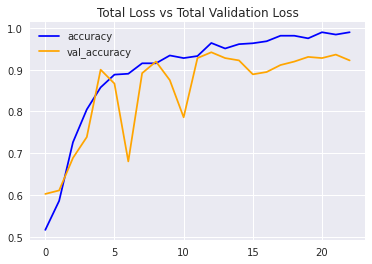

In [27]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# **Predicting the Test Set**

In [28]:
labels_predict = MoBiLSTM_model.predict(features_test)

In [29]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [30]:
labels_test_normal.shape , labels_predict.shape

((200,), (200,))

Accuracy Score

In [31]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.935


Confusion Matrix

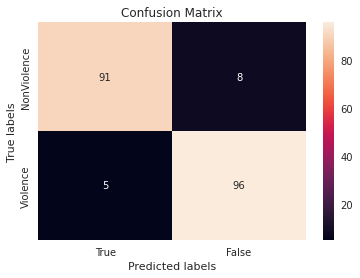

In [32]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Classification Report

In [33]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.92      0.93        99
           1       0.92      0.95      0.94       101

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



# **Prediction Frame By Frame**

In [34]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    predicted_class_name = ''
 
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
 
        frames_queue.append(normalized_frame)
 
       
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [35]:
plt.style.use("default")

def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

In [36]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

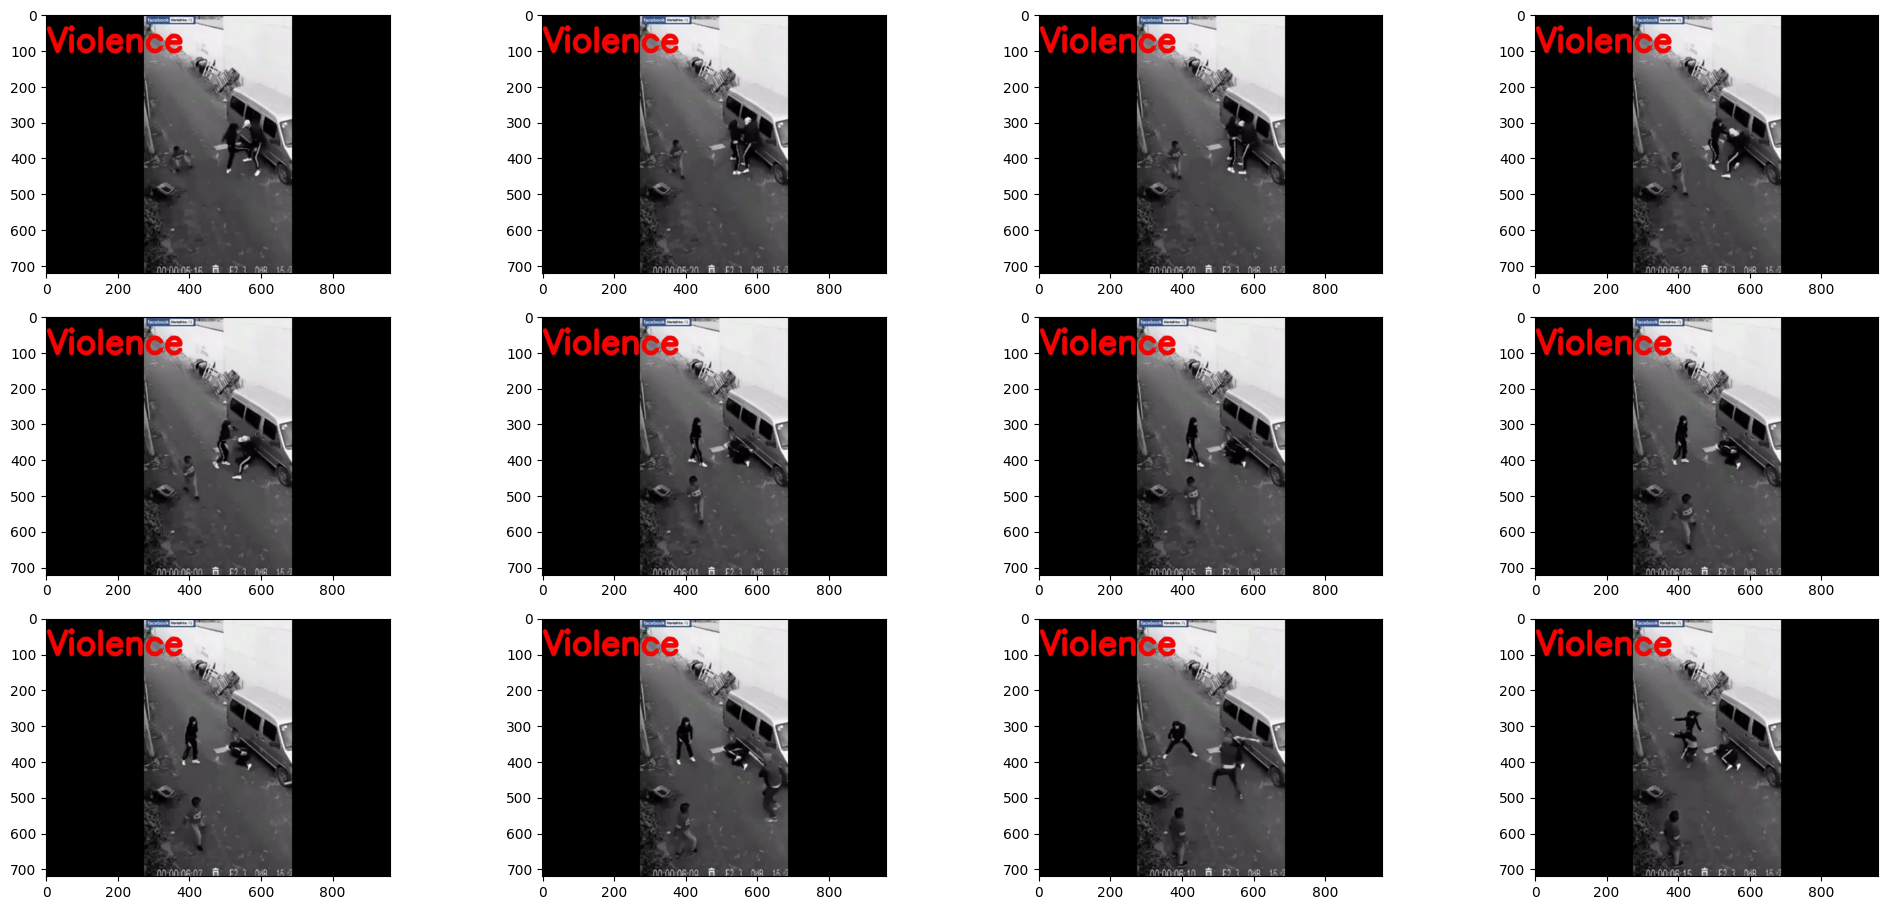

In [37]:
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_370.mp4"

predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

In [38]:
Play_Video(input_video_file_path)

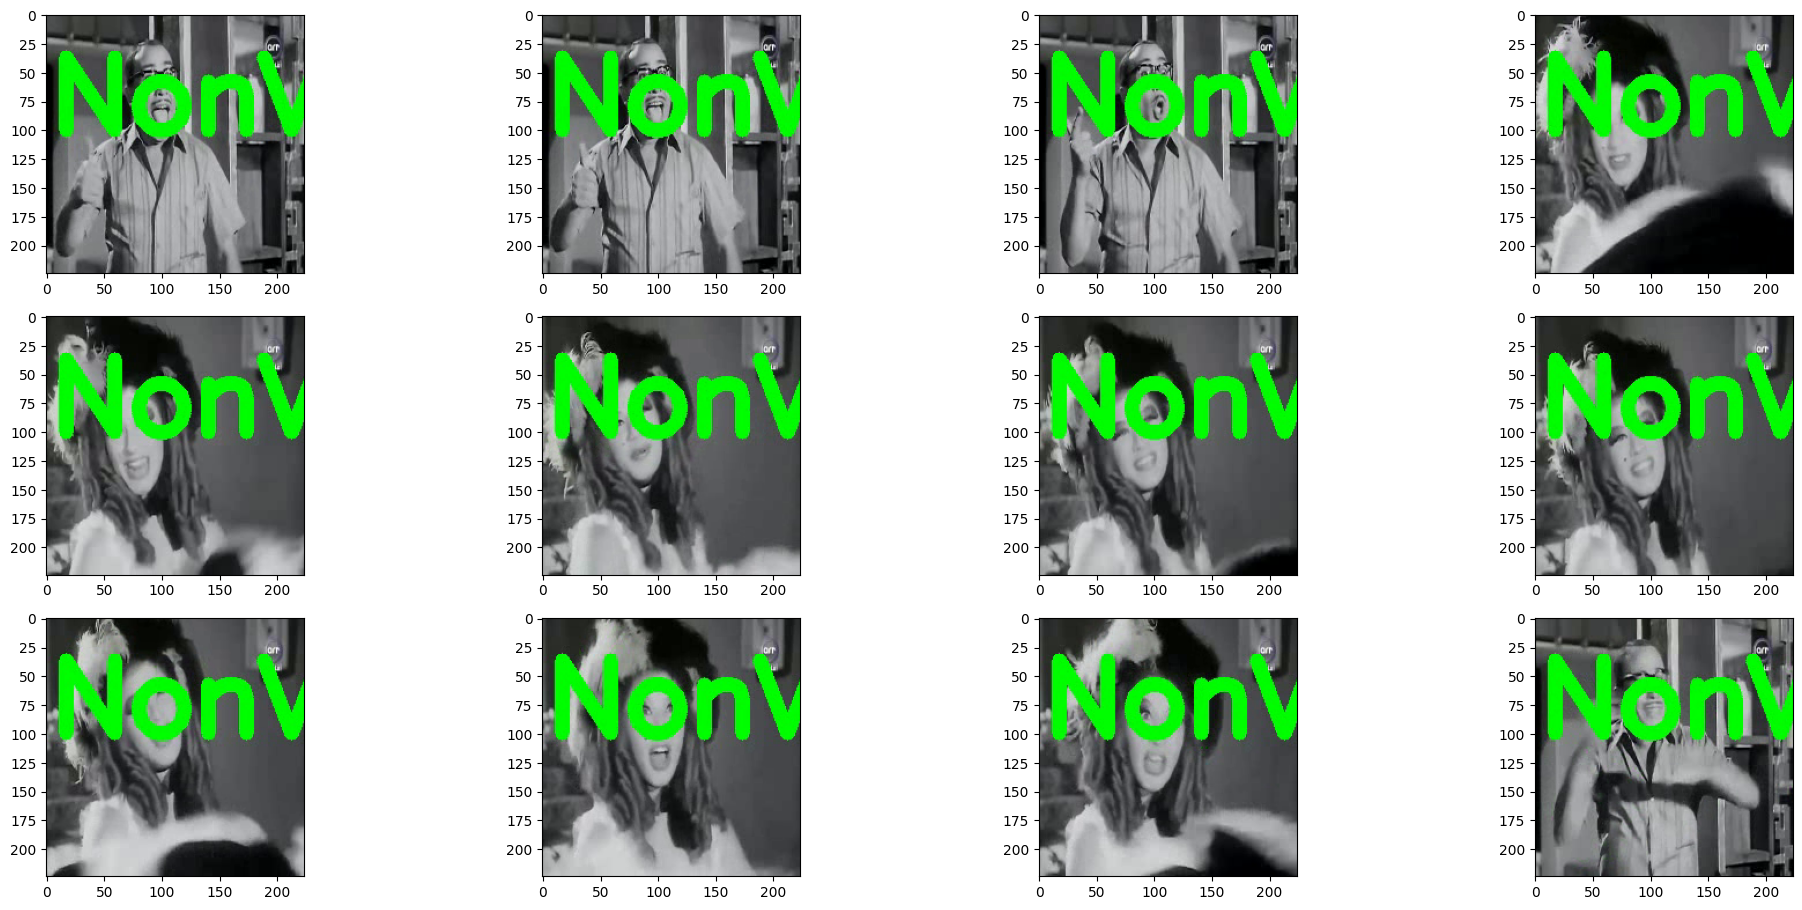

In [39]:
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_2.mp4"

predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

In [40]:
Play_Video(input_video_file_path)

# **Prediction For The Video**

In [41]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    frames_list = []
    
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
 
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [42]:
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_276.mp4"
predict_video(input_video_file_path, SEQUENCE_LENGTH)
Play_Video(input_video_file_path)

Predicted: Violence
Confidence: 0.9992121458053589
